# Microsoft Palette
Palette file (\*.pal) is a binary file consisiting of the list of colors in hexadecimal format. Such files are used by various software, e.g. Originlab. 
Recent versions of Origin have nice set of palettes but sometimes own-designed one is desired/preferred.
PAL file consists of the header (24 bytes) and the list of colors, 4 bytes per color (RGBA). The header includes:
- ASCII text '**RIFF**'
- INT number *file_size-8*
- ASCII text '**PAL data**'
- INT number *file_size-20*
- INT numbers 0, 3, palette_size
, where *palette_size* is the number of colors, and *file_size* = *palette_size*\*4

## Example
Rainbow.pal, default from OriginLab

1052 bytes = Header (24 bytes) + 256 Colors (256x4=1024 bytes) + 4 bytes (Trash?)

First 8\*4=32 bytes: 

In [1]:
f = open('rainbow.pal', 'rb')
for i in range(8):
    l = f.read(4)
    print(l)
f.close()

b'RIFF'
b'\x14\x04\x00\x00'
b'PAL '
b'data'
b'\x08\x04\x00\x00'
b'\x00\x03\x00\x01'
b'l\x00l\x00'
b'p\x00v\x00'


- `b'RIFF'`
- `b'\x14\x04\x00\x00'` = 0x00000414 = 1044
- `b'PAL '`
- `b'data'`
- `b'\x08\x04\x00\x00'` = 0x00000408 = 1032
- `b'\x00\x03\x00\x01'` = 0, 3, 0x0100 = 256 colors
- `b'l\x00l\x00'` First color, RGBA: b'l' = 0x6c = 108, b'\x00' = 0, b'l' = 0x6c = 108, b'\x00' = 0 
- `b'p\x00v\x00'` Second color, RGBA: b'p' = 0x70 = 112, b'\x00' = 0, b'v' = 0x76 = 118, b'\x00' = 0 

In [3]:
import struct
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# get the list of colors from *.pal file:
def read_pal(filename):
    with open(filename, 'rb') as f:
        # no check of consistency
        f.read(22)
        p = f.read(2)
        palette_size = struct.unpack('<H',p)[0]
        colors = []
        for j in range(palette_size):
            p = f.read(3)
            colors.append(struct.unpack('BBB',p))
            f.read(1)
    colors = np.array(colors)
    return colors

In [5]:
colors = read_pal('rainbow.pal')

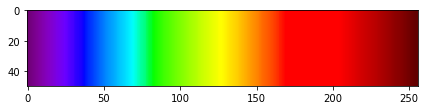

In [6]:
# Show the colormap
plt.rcParams['figure.figsize'] = (7,2)


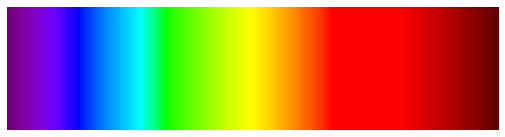

In [13]:
palette_height, palette_width = colors.shape[0] // 4, colors.shape[0]
dpi = 150
fig = plt.figure(figsize=(4*palette_width/dpi, 4*palette_height/dpi))
#fig = plt.figure(figsize=(6, 1.5))
ax = fig.add_axes((0,0,1,1))
ax.axis('off')
o = np.tile(colors, (palette_height,1,1))
plt.imshow(o)
plt.savefig('rainbox.pal.png',dpi=dpi)

In [1]:
def palette(colors, palette_size = 256, pos = None):
    '''
        pos defines the location of the colors in the palette, in not equal spacing is requested
        pos must be the save length as base colors
        e.g. for three colors with pos = [1, 2, 4] and palette size = 10:
        color #0: at first position #0
        color #2: at last position: #9
        color #1: such that distance to color #2 is twice longer than color #0, i.e. (9-0)/(4-1)*(2-1) = 3
    '''
    if type(colors) == list:
        if type(colors[0]) == str:
            colors = [[int(color[1:3],16),int(color[3:5],16),int(color[5:],16)] for color in colors]
    elif type(colors) != np.ndarray:
        colors = np.array(colors)
        if colors.dtype != np.int:
            colors = (colors*255).astype(int)
    if pos is None:
        pos = np.linspace(0, palette_size-1,len(colors)).astype(int)
    else:
        pos = np.array((palette_size-1)*(pos - pos.min())/(pos.max()-pos.min())).astype(int)
    x = np.arange(palette_size)
    out = np.apply_along_axis(lambda a: np.interp(x, pos, a).astype(int), 0, colors)
    return out

In [45]:
# list of lists of colors  - some palettes
# Both hexadecimal and RGB colors are accepted as well as rgb in [0..1] range
cols = [np.array([[55,49,149],[1,142,248],[73,219,112],[255,255,154],[188,160,112],[143,97,84],[182,154,143],[255,255,255]]), \
        ['#ffffd9', '#edf8b1', '#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#253494', '#081d58'],\
        ['#984ea3','#377eb8','#4daf4a','#ffff33','#ff7f00','#e41a1c'], \
        [[23,127,63],[127,191,127],[255,255,95],[223,127,63],[191,0,31]], \
        [[0,63,191],[0,127,159],[127,191,127],[255,255,95],[223,127,63],[191,0,31],[159,0,0]],\
    ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#f7f7f7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']]

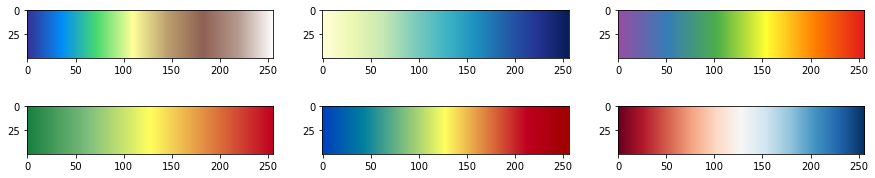

In [46]:
plt.rcParams['figure.figsize'] = (15,5)
for index, col in enumerate(cols):
    plt.subplot(3,3, index+1)
    out = palette(col)
    o = np.tile(out, (50,1,1))
    plt.imshow(o)

In [10]:
# saving the colormap into the file
filename = 'palette.pal' # define filename
# write 'out' into 'palette.pal'
palette_size = out.shape[0]
data_size = palette_size * 4
file_size = data_size + 24
lines = [b'RIFF', struct.pack('<I',file_size-8), b'PAL data', struct.pack('<I',file_size - 20), struct.pack('<BBH',0,3,palette_size)] 
with open(filename,'wb+') as f:
    for line in lines:
        f.write(line)
    for i in range(out.shape[0]):
        line = struct.pack('>BBBB',*out[i, :], 0)
        f.write(line)

NameError: name 'palette_size' is not defined